# CS231a PSET 3 Problem 3: Supervised Monocular Depth Estimation
In this problem we will train a big deep learning model to do monocular depth estimation.

#### For the Notebook, I use CPU since I am on a Mac Jupyternote book. I have ordered a GPU-included desktop so hopefully I will run with GPU in the future, neverthless the model is training fine, maybe a bit slower. There is some small issue with the original code, and I modify all of them.

# Checking out the data

Let's start by having a look at what's in our CLEVR-D dataset. For that, finish the marked sections in data.py, and then run the following code:

Loading dataset zip file...Total number of data points in training set is 1600 with 100 of batches and batch size equals to 16

Mean, min and max of RGB image - -0.013 -4.915 5.723
Mean, min and max of depth image - 0.012 -1.627 1.005



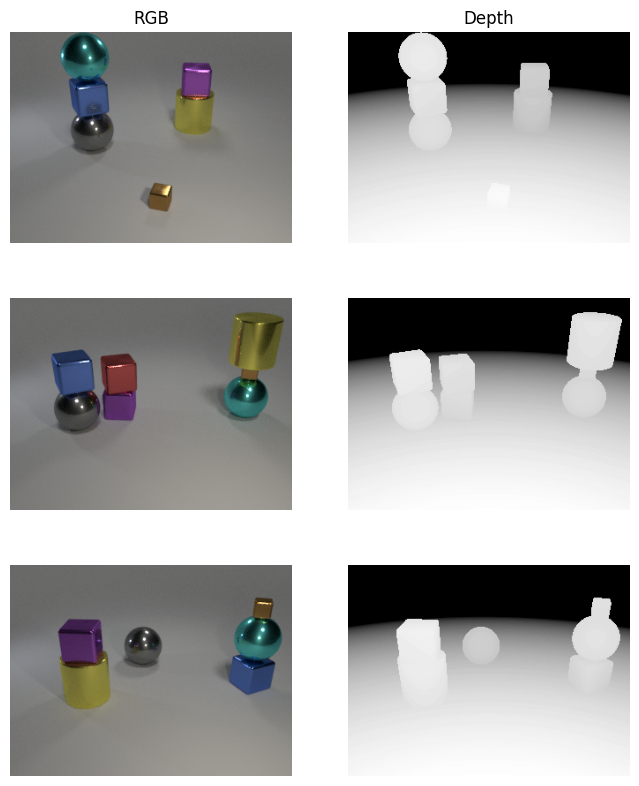

In [1]:
import data
import torch
import torchvision
import matplotlib.pyplot as plt
from importlib import reload 
reload(data)
plt.rcParams['figure.figsize'] = [8,10]
plt.rcParams['figure.dpi'] = 100 

train_data_loader, test_data_loader = data.get_data_loaders("data/cs231a-clevr-rgbd.zip",
                                                is_mono=True,
                                                batch_size=16,#small batch size to conserve memory
                                                train_test_split=0.8,
                                                pct_dataset=0.5)#half of dataset to keep things fast
print('Total number of data points in training set is', len(train_data_loader.dataset), 'with',len(train_data_loader),
      'of batches and batch size equals to 16')
test_data_iter = iter(test_data_loader)
# here we take one BATCH of test data, batch_size is 16 means we have 16 data points where we take mean/min/max values
data_sample = next(test_data_iter)
print("\nMean, min and max of RGB image - %.3f %.3f %.3f"%(
                                          torch.mean(data_sample['rgb']),
                                          torch.min(data_sample['rgb']),
                                          torch.max(data_sample['rgb'])))

print("Mean, min and max of depth image - %.3f %.3f %.3f\n"%(
                                          torch.mean(data_sample['depth']),
                                          torch.min(data_sample['depth']),
                                          torch.max(data_sample['depth'])))

rgb_tensor_to_image, depth_tensor_to_image = data.get_tensor_to_image_transforms()
fig, axs = plt.subplots(3, 2)
axs[0,0].set_title('RGB', size='large')
axs[0,1].set_title('Depth', size='large')
for i in range(3):
    axs[i, 0].imshow(rgb_tensor_to_image(data_sample['rgb'][i]))
    axs[i, 1].imshow(depth_tensor_to_image(data_sample['depth'][i]), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

# Training the model

Next, we can go ahead and train the model once you complete the appropriate parts of losses.py and training.py. 

In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch

import IProgress
import numpy as np  
import pandas as pd
from PIL import Image
from io import BytesIO
import random
from itertools import permutations
import torch  
import torch.nn as nn  
import torch.nn.functional as F 
import torchvision.models as models  

In [3]:
def load_zip_to_mem(zip_file, is_mono=True):
    """
    Function to load CLEVR-D data from the zip file.
    """
    # Load zip file into memory
    print('Loading dataset zip file...', end='')
    from zipfile import ZipFile
    # essentially unzip the file and read all files in it
    input_zip = ZipFile(zip_file)
    file_dict = {name.split('/')[1]: input_zip.read(name) for 
            name in input_zip.namelist() if '.png' in name}
    data = []
    for file_name in file_dict:
      #Only deal with right rgb images, all else via dict lookup
      if 'right' in file_name and 'CLEVR-D' not in file_name:
        rgb_right = file_dict[file_name]
        right_depth_name = file_name.replace('CLEVR','CLEVR-D')
        depth_right = file_dict[right_depth_name]
        if is_mono:
            data.append( (rgb_right, depth_right))
        else:
            rgb_left = file_dict[file_name.replace('right','left')]
            depth_left = file_dict[right_depth_name.replace('right','left')]
            data.append( (rgb_right,rgb_left, depth_right,depth_left))
    print('completed')
    return data

def get_inverse_transforms():
    """
    Get inverse transforms to undo data normalization
    """
    inv_normalize_color = transforms.Normalize(
    mean=[-0.462/0.094, -0.467/0.096, -0.469/0.101],
    std=[1/0.094, 1/0.096, 1/0.101]
    )
    inv_normalize_depth = transforms.Normalize(
    mean=[-0.480/0.295],
    std=[1/0.295]
    )

    return inv_normalize_color, inv_normalize_depth

def get_tensor_to_image_transforms():
    """
    Get transforms to go from Pytorch Tensors to PIL images that can be displayed
    """
    tensor_to_image = transforms.ToPILImage()
    inv_normalize_color, inv_normalize_depth = get_inverse_transforms()
    return (transforms.Compose([inv_normalize_color,tensor_to_image]),
            transforms.Compose([inv_normalize_depth,tensor_to_image]))

class DepthDatasetMemory(Dataset):
    """
    The Dataset class 

    Arguments:
        data (int): list of tuples with data from the zip files
        is_mono (boolen): whether to return monocular or stereo data
        start_idx (int): start of index to use in data list  
        end_idx (int): end of index to use in data list
    """
    def __init__(self, data, is_mono=True, start_idx=0, end_idx = None):
        self.is_mono = is_mono
        self.start_idx = 0
        if end_idx is None:
            end_idx = len(data)
        self.end_idx = end_idx
        # in fact in general case list() is redundant as inside already is list
        self.data = list(data[start_idx:end_idx])

        self.color_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.462, 0.467, 0.469), (0.094, 0.096, 0.101)),
        ])

        self.depth_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.480,), (0.295,)),
        ])

        self.samples = []
        for idx in range(len(self.data)):
            sample = self.data[idx]
            rgb_right = self.color_transform(Image.open(BytesIO(sample[0])).convert('RGB'))
            depth_right = self.depth_transform(Image.open(BytesIO(sample[1])).convert('L'))
            if self.is_mono:
                sample = {'rgb': rgb_right, 'depth': depth_right}
            else:
                rgb_left = self.color_transform(Image.open(BytesIO(sample[2])).convert('RGB'))
                depth_left = self.depth_transform(Image.open(BytesIO(sample[3])).convert('L'))

                sample = {'rgb_right': rgb_right, 'depth_right': depth_right,
                        'rgb_left': rgb_left, 'depth_left': depth_left}
            self.samples.append(sample)

    def __getitem__(self, idx):
        if self.start_idx<=idx<self.end_idx:
            return self.samples[idx]
        else:
            raise ValueError('idx input out of range')

    def __len__(self):
        return len(self.data)
    
    
def get_data_loaders(path, 
                    is_mono=True, 
                    batch_size=16, 
                    train_test_split=0.8, 
                    pct_dataset=1.0):
    """
    The function to return the Pytorch Dataloader class to iterate through
    the dataset. 

    Arguments:
        is_mono (boolen): whether to return monocular or stereo data
        batch_size (int): batch size for both training and testing 
        train_test_split (float): ratio of data from training to testing
        pct_dataset (float): percent of dataset to use 
    """

    data = load_zip_to_mem(path)
    if pct_dataset<1.0:
        N = int(pct_dataset * len(data))
        dataset = random.sample(data, N)
    else:
        N = len(data)
        # One should preferrably shuffle the entire dataset (Although this question don't seem to require it)
        # data = random.shuffle(data)
        
    train_start_idx = 0
    train_end_idx = int(N*train_test_split) 
    test_start_idx = train_end_idx
    test_end_idx = N

    training_dataset = DepthDatasetMemory(data, is_mono=is_mono, start_idx=train_start_idx, end_idx = train_end_idx)
    testing_dataset = DepthDatasetMemory(data, is_mono=is_mono, start_idx=test_start_idx, end_idx = test_end_idx)

    return (DataLoader(training_dataset, batch_size, shuffle=True, pin_memory=True),
            DataLoader(testing_dataset, batch_size, shuffle=False, pin_memory=True))

def get_data_loaders(path, 
                    is_mono=True, 
                    batch_size=16, 
                    train_test_split=0.8, 
                    pct_dataset=1.0):
    """
    The function to return the Pytorch Dataloader class to iterate through
    the dataset. 

    Arguments:
        is_mono (boolen): whether to return monocular or stereo data
        batch_size (int): batch size for both training and testing 
        train_test_split (float): ratio of data from training to testing
        pct_dataset (float): percent of dataset to use 
    """

    data = load_zip_to_mem(path)
    if pct_dataset<1.0:
        N = int(pct_dataset * len(data))
        dataset = random.sample(data, N)
    else:
        N = len(data)
        # One should preferrably shuffle the entire dataset (Although this question don't seem to require it)
        # data = random.shuffle(data)
        
    train_start_idx = 0
    train_end_idx = int(N*train_test_split) 
    test_start_idx = train_end_idx
    test_end_idx = N

    training_dataset = DepthDatasetMemory(data, is_mono=is_mono, start_idx=train_start_idx, end_idx = train_end_idx)
    testing_dataset = DepthDatasetMemory(data, is_mono=is_mono, start_idx=test_start_idx, end_idx = test_end_idx)

    return (DataLoader(training_dataset, batch_size, shuffle=True, pin_memory=True),
            DataLoader(testing_dataset, batch_size, shuffle=False, pin_memory=True))

### Model Construction: Encoder-Densenet Decoder-Upsample+Concatenate+Conv2D

Worth Noting that the 'DenseNet161' has 12 components in its network. Thus in latter features, the decoder uses indices upto 11.

In [4]:
class Encoder(nn.Module):

    def __init__(self, encoder_pretrained=True):
        super(Encoder, self).__init__()
        # the propagation of densenet is not consecutive feedforward
        # it is rather each layer takes all previous layer's output
        self.densenet = models.densenet161(pretrained=encoder_pretrained)
    
    # forward propagation, note all previous output is incorporated into the special layer
    # this is the propagation for the densenet 
    def forward(self, x):
        
        feature_maps = [x]
        # each of the value actually correspond to each layer (a function)
        # inside the network structure
        for key, value in self.densenet.features._modules.items():
            # value is more like the function which characterize the current layer
            feature_maps.append(value(feature_maps[-1]))
        
        return feature_maps
    
"""
Essentially doing a concatenation (after interpolate), then Convolution_ReLU twice, with target channel number
"""
class Upsample(nn.Module):

    def __init__(self, input_channels, output_channels):

        super(Upsample, self).__init__() 

        self.input_channels = input_channels
        self.output_channels = output_channels
        # num_input_channels, num_output_channels, kernel size, stride value, padding value
        self.convA = nn.Conv2d(input_channels, output_channels, 3, 1, 1)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_channels, output_channels, 3, 1, 1)

    def forward(self, x, concat_with):
        # x shape (BatchSize, NumChannel, x_h_dim, x_w_dim)
        # concat_with shape (BatchSize, ConcatNumChannels, concat_h_dim, concat_w_dim)
        concat_h_dim = concat_with.shape[2]
        concat_w_dim = concat_with.shape[3]
        # x gets upsampled to have same shape with 'concat_with' tensor
        upsampled_x = F.interpolate(x, size=[concat_h_dim, concat_w_dim], mode="bilinear", align_corners=True)
        # Interpolated output shape (BatchSize, NumChannel, concat_h_dim, concat_w_dim)
        
        # upsampled x is then concatenated with the 'concat_with' tensor, works only when shape is same except 
        # for the concatenating dimension, which is why we wish to do interpolation
        upsampled_x = torch.cat([upsampled_x, concat_with], dim=1)
        # concatenated tensor went through a few layers of propagation
        upsampled_x = self.convA(upsampled_x)
        upsampled_x = self.leakyrelu(upsampled_x)
        upsampled_x = self.convB(upsampled_x)
        upsampled_x = self.leakyrelu(upsampled_x)

        return upsampled_x


class Decoder(nn.Module):

    def __init__(self, num_features=2208, decoder_width=0.5, scales=[1, 2, 4, 8]):

        super(Decoder, self).__init__()

        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, 1, 1, 1)
        # Reduce number of channels recursively through Upsample layer
        self.upsample1 = Upsample(features//scales[0] + 384, features//(scales[0] * 2))
        self.upsample2 = Upsample(features//scales[1] + 192, features//(scales[1] * 2))
        self.upsample3 = Upsample(features//scales[2] + 96, features//(scales[2] * 2))
        self.upsample4 = Upsample(features//scales[3] + 96, features//(scales[3] * 2))
        # Convolution layer to shrink to singel channel
        self.conv3 = nn.Conv2d(features//(scales[3] * 2), 1, 3, 1, 1)
        # Enlarge the last tow dimensions (Height & Weight) according to the scale_factor
        # This is actually upsampling, the prev stuff is not and contrary.
        self.final_upsample = torch.nn.UpsamplingNearest2d(scale_factor = 2)
        
        
    """
    It left me wondering HOW one choose out to connect only the 3,4,6,8,11 encoder layers with decoder layer
    Other numerous choices are not as good as this one? Why?
    """
    def forward(self, features):
        # It looks like each layer's output in the Encoder is feeded into the Decoder at respective layers (reversely)
        # Taking idea from the 'Dense Connection', note that concatenation is done for the decoder layer input, not output
        # There is no dense connection among decoder layers, but rather between decoder layers and encoder layers.
        # Interpolation is useful since in practice NumChannels varies and we want the model to work for all cases
        # So we specify a target NumChannels shrinking values in these Upsample layers and Interpolate to reshape input
        x_block0= features[3]
        x_block1 = features[4]
        x_block2 = features[6]
        x_block3 = features[8]
        x_block4 = features[11]

        x0 = self.conv2(x_block4)
        x1 = self.upsample1(x0, x_block3)
        x2 = self.upsample2(x1, x_block2)
        x3 = self.upsample3(x2, x_block1)
        x4 = self.upsample4(x3, x_block0)

        cnn_out = self.conv3(x4)

        return self.final_upsample(cnn_out)
        
class DenseDepth(nn.Module):

    def __init__(self, encoder_pretrained=True):
        super(DenseDepth, self).__init__()
        
        # Initialize encoder and decoder here
        self.encoder = Encoder(encoder_pretrained)
        self.decoder = Decoder()
    
    def forward(self, x):
        feature_maps = self.encoder(x)
        output = self.decoder(feature_maps)
        return output


Let's first initialize the model to pass into the training function and confirm that given an rgb image it outputs a depth image.

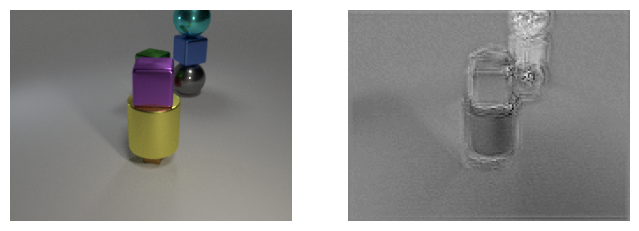

In [5]:
import model
from utils import colorize

dense_depth_model = DenseDepth(encoder_pretrained=False)
sample_image = next(test_data_iter)
with torch.no_grad():
    model_out = dense_depth_model(sample_image['rgb'])
fig, axs = plt.subplots(1, 2)
axs[0].imshow(rgb_tensor_to_image(sample_image['rgb'][0]))
axs[1].imshow(depth_tensor_to_image(model_out[0]),cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
del sample_image
del model_out

In initializing the model we could actually use feature transfer from prior training on [ImageNet](https://en.wikipedia.org/wiki/ImageNet) -- which is a common practice -- by setting encoder_pretrained=True. However, since our data is quite different from that of ImageNet that would actually hinder learning rather than improve it. You can try it if you'd like and see how it impacts the final results!

In [6]:
"""
Explaination of usage of Contiguous memory:
https://stackoverflow.com/questions/48915810/pytorch-what-does-contiguous-do

Essentially expand/view/transpose produces only shallow copy of the origin tensor, and values change
in the origin tensor passes to this shallow copy, thus in order to create a deep copy, we use the .contiguous()
to allocate the new tensor with a different memory storing spot.
"""
def gaussian(window_size, sigma):
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    # include NumBatch and NumChannel dimenison and compute a 2D Gaussian PDF over square with side width = window_size 
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    # expand only works on dimension with value '1' (singleton dimensions)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    # window shape: (channel, 1, window_size, window_size)
    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    """
    SSIM loss for overall perceptual image similarity
    https://en.wikipedia.org/wiki/Structural_similarity
    """
    
    L = val_range

    pad = window_size // 2
    # if report an error skip the try part (in this case when no NumBatch dimension exist for img1)
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    """
    At groups= in_channels, each input channel is convolved with its own set of filters
    It makes sense to use this as we are Duplicating the window into all channels anyway
    This setting makes a difference especially during training
    Original SSIM: (According to 2004 Paper)
    1. for a patch of the picture, which we call window, its mean pixel value represents the luminance
    2. Its pixel values' variance represent the contrast
    3. The covariance between two such windows' pixel values represent their tendency of varying together (structural similarity)
    
    About This Code: (Modified SSIM, one who wrote paper usually differ from person who code)
    1. In practice, one need to choose these Windows, here a Gaussian filter Convolution applied to the image
       is viewed as taking the average over all windows
    2. We are still unfamiliar with the Conv2D operation, but it can be seen that a 2dConvolution based on a 1/N-valued
       square matrix filter will give back the Original defined Mean over each windows, concatenated together to Height/Weight
    3. Thus essentially this code change from an average to a weighted average for computation of 'windows mean'
    4. Such modification unavoidably focus the comparison on center of each windows and neglect the edge elements
    5. However since we use unit stride, each pixels get attention in one window neverthless.
    6. By comparing all similarity over respective windows' luminance, contrast and structural similarity, SSIM
       information is likely to be retained.
    """
    # groups=channels are required to be compatible with window.shape[1]=1
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability, L=1 as per original SSIM paper (wiki)
    C1 = (0.01 ) ** 2  
    C2 = (0.03 ) ** 2 
    # This is NOT the contrast metric, it is the product of contrast(x,y) and structural_similarity(x,y) element-wise
    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    # Strategy here is still to average over all windows to get global similarity
    contrast_metric = torch.mean(contrast_metric)
    # Element-wise SSIM score computation for each pair of windows at same position on the two images
    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)
    if size_average:
        # averages over all the samples, all channels, all pixels, output s single value
        ret = ssim_score.mean() 
    else: 
        # average over all channels, all pixels, output shape [# samples]
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        # output resulting SSIM score and the pair-wise product of contrast with structral similarity
        return ret, contrast_metric
    
    return ret

def image_gradients(img, device):
    """
    Gets gradients along the y and x directions, to use in depth_loss
    """
    img_shape = img.shape
    batch_size, channels, height, width = img.shape
    # note that this potentially operate vecotrizly over all samples
    dy = img[:, :, 1:, :] - img[:, :, :-1, :]
    dx = img[:, :, :, 1:] - img[:, :, :, :-1]
    # padding to fit dy into shape of the img: I believe the order is reversed here
    dy_padding = torch.zeros([batch_size, channels, 1, width], device=device, dtype=img.dtype)
    dy = torch.cat([dy_padding, dy], dim=2)
    # padding to fit dx into shape of the img
    dx_padding = torch.zeros([batch_size, channels, height, 1], device=device, dtype=img.dtype)
    dx = torch.cat([dx_padding, dx], dim=3)

    return dy, dx

def depth_loss(y_true, y_pred, theta=0.1, device="cuda"):
    """
    A loss to penalize differences along edges specifically, to encourage
    better image sharpness.
    """
    # Edges 
    # Get the images gradients of the true data 
    dy_true, dx_true = image_gradients(y_true, device)
    # Get the images gradients of the predicted data
    dy_pred, dx_pred = image_gradients(y_pred, device)    
    # The mean absolute difference between the true and predicted gradients
    # with the following logic: mean(abs(dy_pref-dy_true) + abs(dx_pred-dx_true)) ; take the mean along dimension 1
    l_edges = torch.mean(abs(dy_pred-dy_true) + abs(dx_pred-dx_true), dim=1)
    
    return l_edges

In [7]:
test_sample = next(test_data_iter)

In [13]:
depth_loss(test_sample['depth'], test_sample['depth'], theta=0.1, device='cpu')

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

### Training

In [13]:
import os
import argparse as arg 
import datetime

import torch  
import torch.nn as nn  
import torch.nn.utils as utils
import torch.optim as optim
import torchvision.utils as vision_utils  
#from tensorboardX import SummaryWriter

import data
from losses import ssim as ssim_criterion
from losses import depth_loss as gradient_criterion
from utils import AverageMeter, colorize, init_or_load_model

### Training

In [14]:
"""
When one wish to use a saved Check point and start training from there
the checkpoint needs to be a os.path with name of the .pt file included
in order for this function to be working
"""
def train(epochs, 
        train_data_loader,
        test_data_loader,
        lr=0.0001, 
        save="checkpoints/", 
        theta=0.1, 
        device="cuda", 
        pretrained=False,
        checkpoint=None,
        model=None,
        start_epoch=0):

    num_trainloader = len(train_data_loader)
    num_testloader = len(test_data_loader)

    # Training utils  
    model_prefix = "monocular_"
    device = torch.device("cuda:0" if device == "cuda" else "cpu")
    theta = theta
    save_count = 0
    epoch_loss = []
    batch_loss = []
    sum_loss = 0
    if model is not None:
        # If we have input a Model already, then we initialize an optimizer and train on this model
        # Plus we assume with given model, start epoch must be ZERO, weird setup
        print("Using passed in model...")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # In the checkpoit, which is a file's path, we save the state_dict for torch Module, a Optimizer, and check point epoch
    else:
        if checkpoint:
            print("Loading from checkpoint ...")
        else:
            print("Initializing fresh model ...")
        
        model, optimizer, start_epoch = init_or_load_model(pretrained=pretrained,
                                                            epochs=epochs,
                                                            lr=lr,
                                                            ckpt=checkpoint, 
                                                            device=device                                            
                                                            )
        print("Resuming from: epoch #{}".format(start_epoch))

        model = model.to(device)

    
    #log_dir = 'runs'
    # Logging
    #writer = SummaryWriter(log_dir,comment="{}-training".format(model_prefix))
    
    # Loss functions 
    l1_criterion = torch.nn.L1Loss()

    # Starting training 
    print("Starting training ... ")
     
    for epoch in range(start_epoch, epochs):
        
        batch_time = AverageMeter() 
        l1_loss_meter = AverageMeter() 
        gradient_loss_meter = AverageMeter() 
        ssim_loss_meter = AverageMeter() 
        net_loss_meter = AverageMeter() 
        
        model.train()
        epoch_start = time.time()
        end = time.time()
        

        for idx, batch in enumerate(train_data_loader):

            optimizer.zero_grad() 

            image_x = batch["rgb"].to(device)
            depth_y = batch["depth"].to(device)

            preds = model(image_x) # Call model on the image input to get its predictions

            # calculating the losses 
            l1_loss = l1_criterion(preds, depth_y) # Call the l1_criterion with the predictions and normalized depth
            
            # SSIM Similarity is reversed to represent Loss or Dis-similarity
            # Clamp is applied to control its Scale for stability 
            ssim_loss = torch.clamp(
                (1-ssim_criterion(preds, depth_y, 1.0))*0.5, 
                min=0, 
                max=1
            )

            # Gradient loss checks for the edges of the image to be similar
            gradient_loss = gradient_criterion(depth_y, preds, theta=theta, device=device)

            net_loss = ((1.0 * ssim_loss) + (torch.mean(gradient_loss)) + 
                       (theta * torch.mean(l1_loss)))
            
            batch_size = image_x.size(0)
            l1_loss_meter.update(theta * torch.mean(l1_loss).data.item(), batch_size)
            gradient_loss_meter.update(torch.mean(gradient_loss).data.item(), batch_size)
            ssim_loss_meter.update(ssim_loss.data.item(), batch_size)
            net_loss_meter.update(float(net_loss.data.item()), batch_size)
    
            # back propagate and one-step optimization
            net_loss.backward()
            optimizer.step()

            # Time metrics 
            batch_time.update(time.time() - end)
            end = time.time()
            eta = str(datetime.timedelta(seconds=int(batch_time.val*(num_trainloader-idx))))

            # Logging  
            num_iters = epoch * num_trainloader + idx + 1 
            if (idx + 1 )% 5 == 0 :
                print(
                    "Epoch: #{0} Batch: {1}/{2}\t"
                    "Time (current/total) {batch_time.val:.3f}/{batch_time.sum:.3f}\t"
                    "eta {eta}\t"
                    "LOSS (current/average) {loss.val:.4f}/{loss.avg:.4f}\t"
                    .format(epoch+1, idx+1, 
                            num_trainloader, 
                            batch_time=batch_time, 
                            eta=eta, 
                            loss=net_loss_meter)
                )
                
                # Unless we are on Google Cloud or have access to GPU, forget about these stuff
                #writer.add_scalar("Train/L1 loss", l1_loss_meter.val, num_iters)
                #writer.add_scalar("Train/Gradient Loss", gradient_loss_meter.val, num_iters)
                #writer.add_scalar("Train/SSIM Loss", ssim_loss_meter.val, num_iters)
                #writer.add_scalar("Train/Net Loss", net_loss_meter.val, num_iters)
            
            # Unfortunately unavailability to TensorboardX
            #if (idx + 1) % 20 == 0: 
            #    log_progress_images(model, writer, test_data_loader, num_iters, device)
            
            # torch.save don't allow automatic directory creation
            if not os.path.exists(save):
                os.makedirs(save)
            
            if (idx + 1) % 100 == 0:
                ckpt_path = save+"ckpt_{}.pth".format(epoch)
                torch.save({
                    "epoch": epoch, 
                    "model_state_dict": model.state_dict(),
                    "optim_state_dict":  optimizer.state_dict(),
                }, ckpt_path) 
            del image_x
            del depth_y
            del preds   
        
        # Test Section
        test_net_loss_meter = AverageMeter() 
        model.eval()
        for idx, batch in enumerate(test_data_loader):

            image_x = batch["rgb"].to(device)
            depth_y = batch["depth"].to(device)

            with torch.no_grad():
                preds = model(image_x)

            # calculating the losses 
            l1_loss = l1_criterion(preds, depth_y)
            ssim_loss = torch.clamp(
                (1-ssim_criterion(preds, depth_y, 1.0))*0.5, 
                min=0, 
                max=1
            )
            gradient_loss = gradient_criterion(depth_y, preds, device=device)

            test_net_loss = ((1.0 * ssim_loss) + (torch.mean(gradient_loss)) + 
                       (theta * torch.mean(l1_loss)))
            
            batch_size = image_x.size(0)
            test_net_loss_meter.update(test_net_loss.data.item(), batch_size)

            del image_x
            del depth_y
        # writer.add_scalar("Test/Net Loss", test_net_loss_meter.avg, num_iters)

        print(
            "----------------------------------\n"
            "Epoch: #{0}, Avg. Net Test Loss: {test_avg_loss:.4f}\n" 
            "----------------------------------"
            .format(
                epoch+1, test_avg_loss=test_net_loss_meter.avg
            )
        )

In [15]:
import torch 
import time
#with torch.no_grad():
#    torch.cuda.empty_cache()
train(5, train_data_loader, test_data_loader, lr=0.0001, device="cpu", model=dense_depth_model)

Using passed in model...
Starting training ... 
Epoch: #1 Batch: 5/100	Time (current/total) 37.915/194.467	eta 1:00:39	LOSS (current/average) 0.1943/0.2054	
Epoch: #1 Batch: 10/100	Time (current/total) 38.223/386.575	eta 0:57:58	LOSS (current/average) 0.1216/0.1757	
Epoch: #1 Batch: 15/100	Time (current/total) 37.818/577.678	eta 0:54:12	LOSS (current/average) 0.1212/0.1569	
Epoch: #1 Batch: 20/100	Time (current/total) 37.534/769.412	eta 0:50:40	LOSS (current/average) 0.1046/0.1444	
Epoch: #1 Batch: 25/100	Time (current/total) 41.347/977.539	eta 0:52:22	LOSS (current/average) 0.0957/0.1352	
Epoch: #1 Batch: 30/100	Time (current/total) 40.997/1181.239	eta 0:48:30	LOSS (current/average) 0.0887/0.1281	
Epoch: #1 Batch: 35/100	Time (current/total) 44.028/1385.197	eta 0:48:25	LOSS (current/average) 0.0969/0.1225	
Epoch: #1 Batch: 40/100	Time (current/total) 42.038/1602.516	eta 0:42:44	LOSS (current/average) 0.0941/0.1187	
Epoch: #1 Batch: 45/100	Time (current/total) 40.283/1803.951	eta 0:37:

Yay! If you implemented everything correctly, the loss went down and you saw the model work well. There should be files in the checkpoints directory now, which correspond to model weights throughout different points in training. We won't be using these, but it's standard in deep learning to generate these to later load for running the model for experiments or for futher fine-tuning. We can now again take a look at its output for a given image and see what it does on test set inputs:

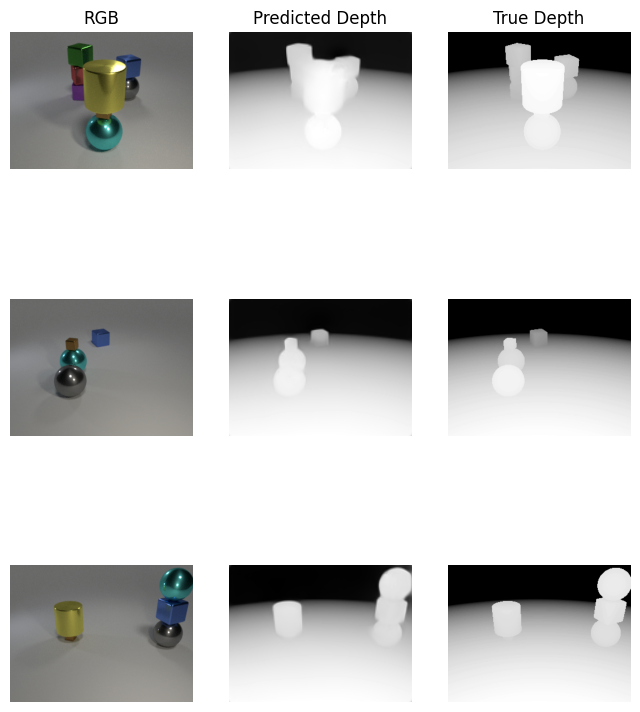

In [16]:
#we'll iterate to pick a nice set of images
for i in range(5): # feel free to change this to see other outputs
    sample_image = next(test_data_iter)
with torch.no_grad():
    model_out = dense_depth_model(sample_image['rgb'].to('cpu')) 
fig, axs = plt.subplots(3, 3)
axs[0,0].set_title('RGB', size='large')
axs[0,1].set_title('Predicted Depth', size='large')
axs[0,2].set_title('True Depth', size='large')
depth_inverse_normalize = data.get_inverse_transforms()[1]
for i in range(3):
    axs[i, 0].imshow(rgb_tensor_to_image(sample_image['rgb'][i]))
    axs[i, 1].imshow(depth_inverse_normalize(model_out[i]).data.cpu().numpy()[0], cmap='gray')
    axs[i, 2].imshow(depth_tensor_to_image(sample_image['depth'][i]), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')

We can see that the model is largely doing the right thing, although if you look closely it's also evident it is not able to capture some of the smaller nuances of depth disparities between objects.

# Conclusion

That's it! You have now trained a model for monocular depth estimation. As noted in the PDF, you now just need to download this notebook to submit alongside your python files.

Credits: this assignment was adapted from [this](https://github.com/pranjaldatta/DenseDepth-Pytorch) code base.
